# Assignment 29.10.2018 # 


## Authors: Jan Zahn, Jonas Meier, Thomas Wiktorin ##
1. Project Living skin detection

The task is: train a classifier which is able to distinguish between living and dead materials with highest success rate
The used NN should have few most distinctive input features i.e. spectral lines

Steps:

Read all XLS and CSV data files into Python.  
Visualize them and based on your insight suggest / try some decent feature classifiers.  
Select them, train them and validate them.  
Analyse runtime and memory footprint.  
Argue why your solution is appropriate.  


## Explanation:##

BUG NOTE: We shuffle the data to get a normalised distribution of datatypes. Sometimes the random shuffle does not shuffle the the data-matrix and class-matrix the same way order, resulting in an unusable model with 50% accuraxy. If this happens, re-run the program.

In our first program we chose to use all 121 values on the input layer, and see how accurate our model is. We reached over 96 percent accuracy consistently. Using different sizes of epochs/batch_size/validation data/training data/test data/hidden layers did not change our results in huge ways. However, I believe the size of the hidden layers is better to be small due to overfitting.   

One problem existed in the unequal representation of classes. The "living Material" has just 6 examples, while the other class is represented by 171 data sets. To reach a high accuracy, our model just classified everything as "dead material" and had instant high training and validation accuracy. Of course, this accuracy is meaningless, since we are often interested in the under represented class.  

At first, we tried to weight our examples by the means of sensitivity and specificity.  

sensitivity = true positives / positives  
specificity = true negatives / negatives  

Our model always predicts dead material and therefore has a sensitivity of 0 and specificity of 1.  
We want to achieve a model that gets close to both sensitivity and specificity beeing 1.  

Weighting did not fix our issues, so we increased the number of positive examples by duplicating them, until the numbers for each class were equal.  
This fixed our issue and we got high accuracy (>95%) and a sensitivity & specificity value close to 1.

In the second program we reduced our number of features, otherwise it is the same. 
We reduced the input layer from 121 to 12.

We looked at the second derivative and the concavity (see program 2 graphs) seemed to provide a few distinct values, important for our few features. We chose the points where the second derivative is in its extremes for both min and max, resulting in a total of 12 points.   
This resulted in a higher accuracy (>98%) and a more stable learning (see last graphs in program two)  

Runtime for an prediction of our model with 12 features takes:  
0.0001302809675962635 seconds  
And with 121:  
0.0001329888860936989 seconds  
  
340 evaluations with 121 features take:  
0.00032795901779536507 seconds  
  
340 evaluations with 12 features take:  
0.000109520259115925  

We get a slight improvement, but with our data and network size, runtime and memory does not seem to matter much.

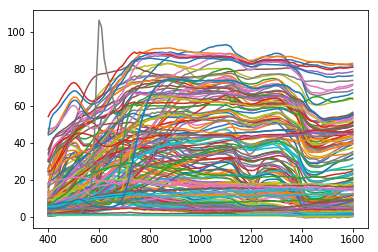

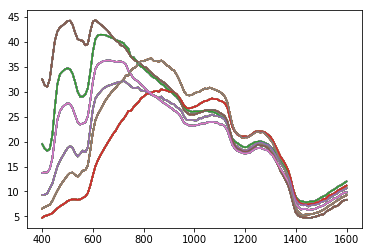

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                1952      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 34        
Total params: 1,986
Trainable params: 1,986
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 100 samples
Epoch 1/50
200/200 [==============================] - 0s 2ms/step - loss: 2.7891 - acc: 0.4150 - val_loss: 0.9722 - val_acc: 0.5400
Epoch 2/50
200/200 [==============================] - 0s 168us/step - loss: 1.0996 - acc: 0.6200 - val_loss: 0.4251 - val_acc: 0.6900
Epoch 3/50
200/200 [==============================] - 0s 125us/step - loss: 0.7758 - acc: 0.7250 - val_loss: 0.3551 - val_acc: 0.8700
Epoch 4/50
200/200 [==============================] - 0s 105us/step - loss: 0.5566 - acc: 

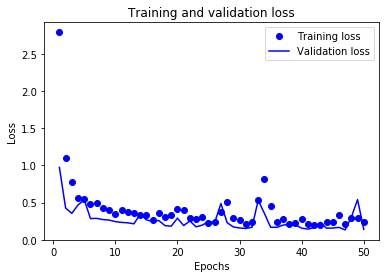

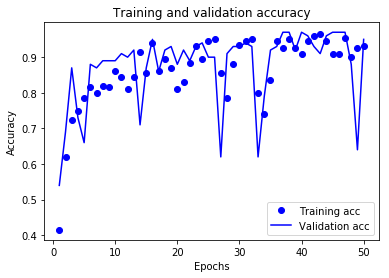

In [5]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import csv

#-------------------------------------------------------------------------------Get Data
dataFiles = ["Fleisch", "Holz", "Leder", "Stoff"]
dataFilesPositives = ["Referenz-Haut_6-Klassen"]

def importData(fileNames):
    data = np.array([]);
    xPoints = np.array([]);
    for dataType in fileNames:
        with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=';')
                
                newList = list(csv_reader)      
                for index, row in enumerate(newList):
                   newList[index] = [value.replace(',', '.') for value in row]
                
                newData = np.asarray(newList)
                newData = np.delete(newData, (0), axis=0)
                if xPoints.size == 0:
                    xPoints = newData[:,0]
                newData = np.delete(newData,(0), axis=1)
                
                if data.size == 0:
                    data = newData.transpose()
                else:
                    data = np.append(data, newData.transpose(),axis=0)
    
        data = data.astype(np.float)
        xPoints =  xPoints.astype(np.float)    
    return xPoints, data 


#Negattives
xValues, data = importData(dataFiles)
#Positives
_, dataPositives = importData(dataFilesPositives)
dataPositives = np.tile(dataPositives,(28,1)) #Increase positives to deal with unbalance class

#--------------------------------------------------------------------------------Plott Data
#Plotting
for row in data:
    plt.plot(xValues,row)
    
plt.show()

for row in dataPositives:
    plt.plot(xValues,row)

plt.show()

#--------------------------------------------------------------------------------Split Up Data [1,0] is dead, [0.1] alive
#CompleteSet
compSet = np.append(data, dataPositives ,axis=0)
classifcSet = np.append(np.tile([1,0],(data.shape[0],1)),np.tile([0,1],(dataPositives.shape[0],1)),axis=0)

#Mix them together #NOTE SOMETIMES THIS DOES NOT RESULT IN THE SAME SHUFFLE
rng_state = np.random.get_state()
np.random.shuffle(compSet)
np.random.set_state(rng_state)
np.random.shuffle(classifcSet)

#Split in training and test Data
trainingSet = compSet[:200]
trainingLabelSet =  classifcSet[:200]

validationSet = compSet[200:300]
validationLabelSet = classifcSet[200:300]

testSet = compSet[300:]
testLabelSet = classifcSet[300:]


#--------------------------------------------------------------------------------Build Model with tensorflow

#Simple answer; number of input layer = number of points on spectral line
spectrum = 120 

model = keras.Sequential() #Single input-output
model.add(keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(121,))) #fully-conndected = dense, with 16 units, relu: rectified linear unit
model.add(keras.layers.Dense(2, activation=tf.nn.softmax)) #Cofidence level

model.summary()

#Optimizer and loss function
model.compile(optimizer=tf.train.AdamOptimizer(), #or sgd(stochastic gradient descent optimizer: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
              loss='binary_crossentropy', #or mean_squared_error (our target is not in the continuos space), but binary seems to deal better with probabilitis
              metrics=['accuracy']
              )

#Weighted class did not solve the unequal class problem
#class_weight={
#        1: 1/100, 2:1/2}

#Train model for 50 epochs in batches of 3 samples
history = model.fit(trainingSet,
                    trainingLabelSet,
                    epochs=50,
                    batch_size=10,  #the bigger the more memory space needed
                    validation_data=(validationSet, validationLabelSet),
                    verbose=1
                    )
                    

results = model.evaluate(testSet, testLabelSet)
print(results)

#--------------------------------------------------------------------------------Print Results
#Plot accuracy and loss over time
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

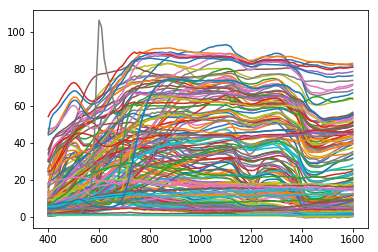

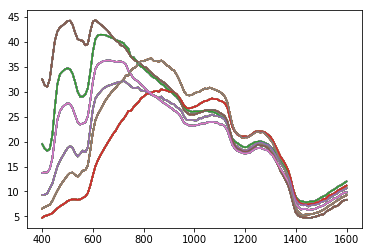

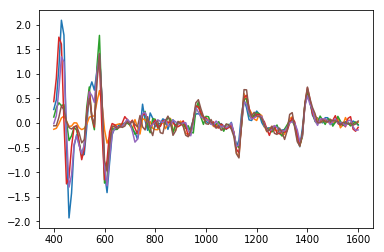

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                208       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 242
Trainable params: 242
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 100 samples
Epoch 1/50
200/200 [==============================] - 0s 1ms/step - loss: 6.1669 - acc: 0.4900 - val_loss: 5.3250 - val_acc: 0.4700
Epoch 2/50
200/200 [==============================] - 0s 95us/step - loss: 3.0693 - acc: 0.5100 - val_loss: 1.0593 - val_acc: 0.7200
Epoch 3/50
200/200 [==============================] - 0s 95us/step - loss: 0.7124 - acc: 0.6300 - val_loss: 0.7008 - val_acc: 0.4500
Epoch 4/50
200/200 [==============================] - 0s 90us/step - loss: 0.6115 - acc: 0.7100 

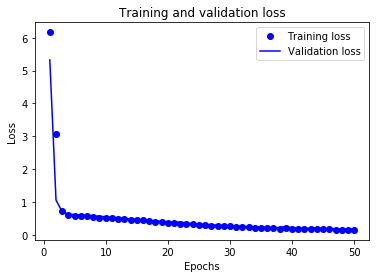

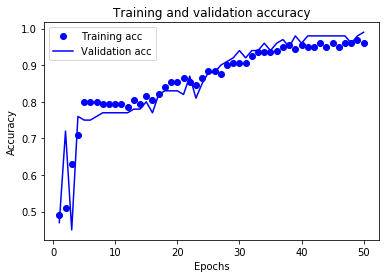

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import csv

#-------------------------------------------------------------------------------Get Data
dataFiles = ["Fleisch", "Holz", "Leder", "Stoff"]
dataFilesPositives = ["Referenz-Haut_6-Klassen"]

def importData(fileNames):
    data = np.array([]);
    xPoints = np.array([]);
    for dataType in fileNames:
        with open("Archiv\\" + dataType + '.csv', mode='r') as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=';')
                
                newList = list(csv_reader)      
                for index, row in enumerate(newList):
                   newList[index] = [value.replace(',', '.') for value in row]
                
                newData = np.asarray(newList)
                newData = np.delete(newData, (0), axis=0)
                if xPoints.size == 0:
                    xPoints = newData[:,0]
                newData = np.delete(newData,(0), axis=1)
                
                if data.size == 0:
                    data = newData.transpose()
                else:
                    data = np.append(data, newData.transpose(),axis=0)
    
        data = data.astype(np.float)
        xPoints =  xPoints.astype(np.float)    
    return xPoints, data 


#Negattives
xValues, data = importData(dataFiles)
#Positives
_, dataPositivesReal = importData(dataFilesPositives)
dataPositives = np.tile(dataPositivesReal,(28,1)) #Increase positives to deal with unbalance class

#--------------------------------------------------------------------------------Plott Data
#Plotting
for row in data:
    plt.plot(xValues,row)
    
plt.show()

for row in dataPositives:
    plt.plot(xValues,row)

plt.show()


#Extra Value for less Features
gradientData = np.empty([dataPositivesReal.shape[0],dataPositivesReal.shape[1]]);
i = 0;
for row in dataPositivesReal:
    gradient = np.gradient(np.gradient(row)) #where does the gradient change fastest
    plt.plot(xValues,gradient)
    gradientData[i] = gradient
    i = i+1
    
plt.show()
#hardcoded
maxGradients = gradientData.argmax(axis=1)
minGradients = gradientData.argmin(axis=1)
smallXValues = np.append(maxGradients,minGradients,axis=0)

smallFeaturesPositiveReal = dataPositivesReal[:,smallXValues]
smallFeaturesPositive = np.tile(smallFeaturesPositiveReal,(28,1)) #Increase positives to deal with unbalance class
smallFeature = data[:,smallXValues]

#--------------------------------------------------------------------------------Split Up Data [1,0] is dead, [0.1] alive
#CompleteSet Small Version
compSet = np.append(smallFeature, smallFeaturesPositive ,axis=0)
classifcSet = np.append(np.tile([1,0],(smallFeature.shape[0],1)),np.tile([0,1],(smallFeaturesPositive.shape[0],1)),axis=0)

#Mix them together #NOTE SOMETIMES THIS DOES NOT RESULT IN THE SAME SHUFFLE
rng_state = np.random.get_state()
np.random.shuffle(compSet)
np.random.set_state(rng_state)
np.random.shuffle(classifcSet)

#Split in training and test Data
trainingSet = compSet[:200]
trainingLabelSet =  classifcSet[:200]

validationSet = compSet[200:300]
validationLabelSet = classifcSet[200:300]

testSet = compSet[300:]
testLabelSet = classifcSet[300:]


#--------------------------------------------------------------------------------Build Model with tensorflow

#Simple answer; number of input layer = number of points on spectral line
spectrum = 120 

model = keras.Sequential() #Single input-output
model.add(keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(12,))) #fully-conndected = dense, with 16 units, relu: rectified linear unit
model.add(keras.layers.Dense(2, activation=tf.nn.softmax)) #Cofidence level

model.summary()

#Optimizer and loss function
model.compile(optimizer=tf.train.AdamOptimizer(), #or sgd(stochastic gradient descent optimizer: keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
              loss='binary_crossentropy', #or mean_squared_error (our target is not in the continuos space), but binary seems to deal better with probabilitis
              metrics=['accuracy']
              )

#Weighted class did not solve the unequal class problem
#class_weight={
#        1: 1/100, 2:1/2}

#Train model for 50 epochs in batches of 3 samples
history = model.fit(trainingSet,
                    trainingLabelSet,
                    epochs=50,
                    batch_size=10,  #the bigger the more memory space needed
                    validation_data=(validationSet, validationLabelSet),
                    verbose=1
                    )
                    

results = model.evaluate(testSet, testLabelSet)
print(results)

#--------------------------------------------------------------------------------Print Results
#Plot accuracy and loss over time
history_dict = history.history
history_dict.keys()

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
# %% Cell 1
import timeit

start = timeit.timeit()
result = model.predict(smallFeature)
end = timeit.timeit()
print(end - start)
